In [1]:
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.'+ paultimothymooney_chest_xray_pneumonia_path)


Data source import complete./kaggle/input/chest-xray-pneumonia


In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Constants

In [3]:
data_dir = "/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"
TRAIN, VAL, TEST = 'train', 'val', 'test'
BATCH_SIZE = 64
EPOCHS = 10
MODEL_PATH = "pneumonia_cnn.pth"

# Data Transformations

In [4]:
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ]),
    VAL: transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ]),
    TEST: transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ]),
}

# Datasets & Dataloaders

In [5]:
trainset = datasets.ImageFolder(os.path.join(data_dir, TRAIN), transform=data_transforms[TRAIN])
validset = datasets.ImageFolder(os.path.join(data_dir, VAL),   transform=data_transforms[VAL])
testset  = datasets.ImageFolder(os.path.join(data_dir, TEST),  transform=data_transforms[TEST])

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader  = DataLoader(testset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = trainset.classes
print("Classes:", class_names)

Classes: ['NORMAL', 'PNEUMONIA']


# Device Configuration

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Model Definition

In [7]:
class PneumoniaCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # Conv Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 14 * 14, 512),  # assuming input 224x224 → 14x14 after 4×pool2
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [8]:
model = PneumoniaCNN().to(device)

# Loss, Optimizer, Scheduler

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training Function with Validation

In [10]:
def train_model(model, trainloader, validloader, epochs):
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, epochs+1):
        # -- Training --
        model.train()
        running_loss = running_corrects = 0
        for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()

        epoch_loss = running_loss / len(trainloader.dataset)
        epoch_acc  = running_corrects / len(trainloader.dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # -- Validation --
        model.eval()
        val_loss = val_corrects = 0
        with torch.no_grad():
            for inputs, labels in validloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = outputs.argmax(dim=1)
                val_corrects += (preds == labels).sum().item()

        val_loss = val_loss / len(validloader.dataset)
        val_acc  = val_corrects / len(validloader.dataset)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        scheduler.step()

        print(f"Epoch {epoch}/{epochs} → "
              f"Train: loss={epoch_loss:.4f}, acc={epoch_acc*100:.2f}% | "
              f" Val: loss={val_loss:.4f}, acc={val_acc*100:.2f}%")

        # Save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

    # load best
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"\nLoaded best model with val_acc={best_val_acc*100:.2f}%")

    return history

# Train the Model

In [11]:
history = train_model(model, trainloader, validloader, EPOCHS)

Epoch 1/10 → Train: loss=1.6321, acc=83.84% |  Val: loss=2.2736, acc=62.50%


Epoch 2/10 → Train: loss=0.2038, acc=91.95% |  Val: loss=2.4572, acc=62.50%


Epoch 3/10 → Train: loss=0.1778, acc=93.81% |  Val: loss=0.6582, acc=62.50%


Epoch 4/10 → Train: loss=0.1668, acc=94.06% |  Val: loss=4.1635, acc=62.50%


Epoch 5/10 → Train: loss=0.1526, acc=95.13% |  Val: loss=1.6511, acc=62.50%


Epoch 6/10 → Train: loss=0.1388, acc=96.09% |  Val: loss=1.1252, acc=68.75%


Epoch 7/10 → Train: loss=0.1325, acc=95.94% |  Val: loss=0.8927, acc=68.75%


Epoch 8/10 → Train: loss=0.1324, acc=95.59% |  Val: loss=1.4376, acc=50.00%


Epoch 9/10 → Train: loss=0.1250, acc=96.09% |  Val: loss=1.0552, acc=68.75%


Epoch 10/10 → Train: loss=0.1276, acc=96.15% |  Val: loss=1.4824, acc=62.50%

Loaded best model with val_acc=68.75%


# Plot Training Curves

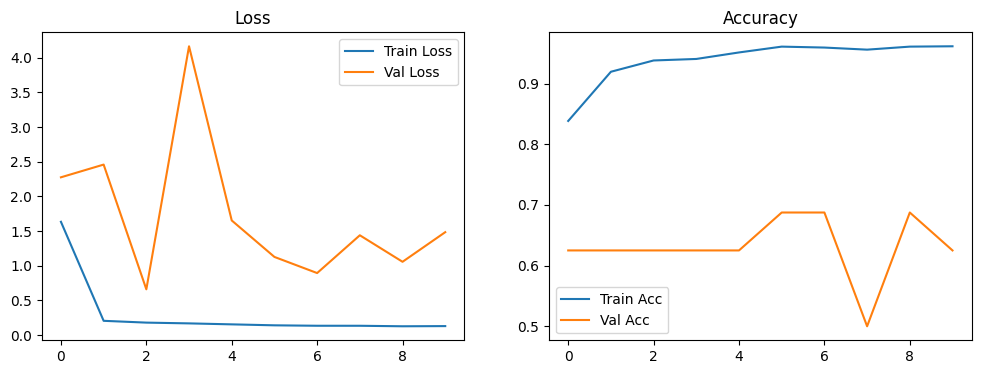

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'],   label='Val Loss')
plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'],   label='Val Acc')
plt.legend(); plt.title("Accuracy")
plt.show()

# Final Testing with Metrics

In [13]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%\n")
print("📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


✅ Test Accuracy: 80.61%

📋 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.50      0.66       234
   PNEUMONIA       0.77      0.99      0.86       390

    accuracy                           0.81       624
   macro avg       0.87      0.74      0.76       624
weighted avg       0.84      0.81      0.79       624



# Metrics

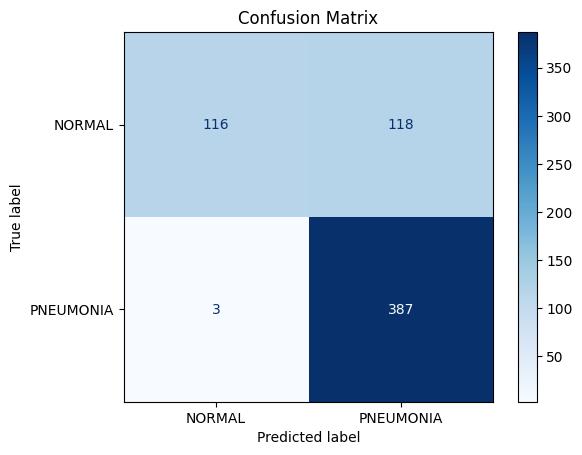

In [14]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Save & Load Model

In [15]:
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

# To reload later:
# loaded_model = PneumoniaCNN().to(device)
# loaded_model.load_state_dict(torch.load(MODEL_PATH))
# loaded_model.eval()

Model saved to pneumonia_cnn.pth
